In [1]:
from nn_globals import *

from nn_encode import (nlayers, nvariables, create_encoder)

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay)

from nn_training import train_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = False

use_highpt = False

model_name = 'model'

epochs = 300

batch_size = 2048

tile = 4

learning_rate = 0.0063

gradient_clip_norm = 100.

add_noise = True

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300
  
  tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 10

### Import data

In [3]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3
if run2_input:
  test_size = 0.304
if omtf_input:
  test_size = 0.311

from functools import partial
create_encoder_1 = partial(create_encoder, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, create_encoder=create_encoder_1, test_size=test_size, no_warn=False)

#FIXME
#y_train = np.abs(y_train)
#y_test = np.abs(y_test)

# Add PU discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut_low/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut_low/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]
  assert(y_train[0].shape == y_train[1].shape)
  assert(y_test[0].shape == y_test[1].shape)

[INFO    ] Loading muon data from ../test7/histos_tba.27.npz ...
[INFO    ] Loaded the variables with shape (3319149, 164)
[INFO    ] Loaded the parameters with shape (3319149, 6)
[INFO    ] Loaded the encoded variables with shape (3319149, 36)
[INFO    ] Loaded the encoded parameters with shape (3319149,)
[INFO    ] Loaded # of training and testing events: (2323404, 995745)


In [4]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_y_train, pu_y_test, pu_dxy_train, pu_dxy_test, pu_dz_train, pu_dz_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test, pu_aux_train, pu_aux_test = \
    pileup_data_split(infile_pileup, create_encoder=create_encoder_1, test_job=test_job)

# Add q/pT output node
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]
  assert(pu_y_train[0].shape == pu_y_train[1].shape)
  assert(pu_y_test[0].shape == pu_y_test[1].shape)

[INFO    ] Loading pileup data from ../test7/histos_tbd.27.npz ...
[INFO    ] Loaded the variables with shape (1086098, 164)
[INFO    ] Loaded the auxiliary PU info with shape (1086098, 4)
[INFO    ] Loaded the encoded variables with shape (1086098, 36)
[INFO    ] Loaded the encoded parameters with shape (1086098,)
[INFO    ] Loaded the encoded auxiliary PU info with shape (1086098, 4)
[INFO    ] Loaded # of training and testing events (PU): (895206, 190892)


In [5]:
# Import highpt data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

highpt_x_train, highpt_x_test, highpt_y_train, highpt_y_test, highpt_dxy_train, highpt_dxy_test, highpt_dz_train, highpt_dz_test, highpt_x_mask_train, highpt_x_mask_test, highpt_x_road_train, highpt_x_road_test = \
    muon_data_split(infile_highpt, create_encoder=create_encoder_1, test_size=test_size)

#FIXME
#highpt_y_train = np.abs(highpt_y_train)
#highpt_y_test = np.abs(highpt_y_test)

# Add PU discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/highpt_y_train) >= discr_pt_cut_low/reg_pt_scale, 1., mask_value)
  highpt_y_train = [highpt_y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/highpt_y_test) >= discr_pt_cut_low/reg_pt_scale, 1., mask_value)
  highpt_y_test = [highpt_y_test, labels.astype(np.float32)]
  assert(highpt_y_train[0].shape == highpt_y_train[1].shape)
  assert(highpt_y_test[0].shape == highpt_y_test[1].shape)

# Include highpt muons into training sample, no changes to the testing sample
if use_highpt:
  # Put the training data into final buckets of 128 (0.9 used to account for validation split)
  new_train_size = int(highpt_x_train.shape[0]*2.*0.9) % 128
  new_train_size = highpt_x_train.shape[0] - int(new_train_size/2./0.9) - 1
  highpt_x_train = highpt_x_train[:new_train_size]
  highpt_y_train = [highpt_y_train[0][:new_train_size], highpt_y_train[1][:new_train_size]]
  highpt_dxy_train = highpt_dxy_train[:new_train_size]
  highpt_dz_train = highpt_dz_train[:new_train_size]

  # Append
  x_train = np.vstack((x_train, highpt_x_train))
  y_train = [np.hstack((y_train[0], highpt_y_train[0])), np.hstack((y_train[1], highpt_y_train[1]))]
  dxy_train = np.hstack((dxy_train, highpt_dxy_train))
  dz_train = np.hstack((dz_train, highpt_dz_train))
  logger.info('Included \'highpt\' {0}, # of training and testing events: {1}'.format((highpt_x_train.shape[0], highpt_x_test.shape[0]), (x_train.shape[0], x_test.shape[0])))

[INFO    ] Loading muon data from ../test7/histos_tbe.27.npz ...
[INFO    ] Loaded the variables with shape (431646, 164)
[INFO    ] Loaded the parameters with shape (431646, 6)
[INFO    ] Loaded the encoded variables with shape (431646, 36)
[INFO    ] Loaded the encoded parameters with shape (431646,)
[INFO    ] Loaded # of training and testing events: (302152, 129494)


### Training

In [6]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator
# BN is applied right after the input layers

if do_training:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    pu_x_train_tmp = ~(pu_aux_train[:,2] > discr_pt_cut_low)
    pu_x_train = pu_x_train[pu_x_train_tmp]
    pu_y_train = [pu_y_train[0][pu_x_train_tmp], pu_y_train[1][pu_x_train_tmp]]
    logger.info('Dropped PU tracks matched to tracking particles, pu_x_train has shape {0}, pu_y_train has shape {1},{2}'.format(pu_x_train.shape, pu_y_train[0].shape, pu_y_train[1].shape))
    # Put together x_train & pu_x_train, y_train & pu_y_train
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, tile=tile)
    logger.info('PU discr training uses sig # of events: {0}, bkg # of events: {1}'.format((y_train_new[1]==1).sum(), (y_train_new[1]==0).sum()))
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm,
                           l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  # Start training
  history = train_model(model, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=[lr_decay,], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1],
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [7]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.ylim(2,7)
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [8]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a", "#bfbf33", "#a65628", "#f781bf")

In [9]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

# Prepare y_test_true, y_test_pred
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true /= reg_pt_scale
if y_test_true.ndim == 1:
  y_test_true = y_test_true[:, np.newaxis]

y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_pred, list):
  y_test_pred, y_test_pred_discr = y_test_pred
y_test_pred /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [10]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = np.full((pu_x_test.shape[0], 1), mask_value, dtype=np.float32)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
if isinstance(pu_y_test_pred, list):
  pu_y_test_pred, pu_y_test_pred_discr = pu_y_test_pred
pu_y_test_pred /= reg_pt_scale
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 124468, mean: 6.031973e-04, std: 3.522103e-02, mse: 1.311483e-03, mae: 2.384662e-02, mad: 2.315473e-02
[INFO    ] gaus fit (a, mu, sig): 1.070355e+04, 5.742800e-04, 2.030968e-02
[INFO    ] # of entries: 20086, mean: 5.883123e-04, std: 1.271725e-02, mse: 3.970040e-04, mae: 9.322485e-03, mad: 8.276379e-03
[INFO    ] gaus fit (a, mu, sig): 1.598651e+03, 4.492157e-04, 7.557042e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


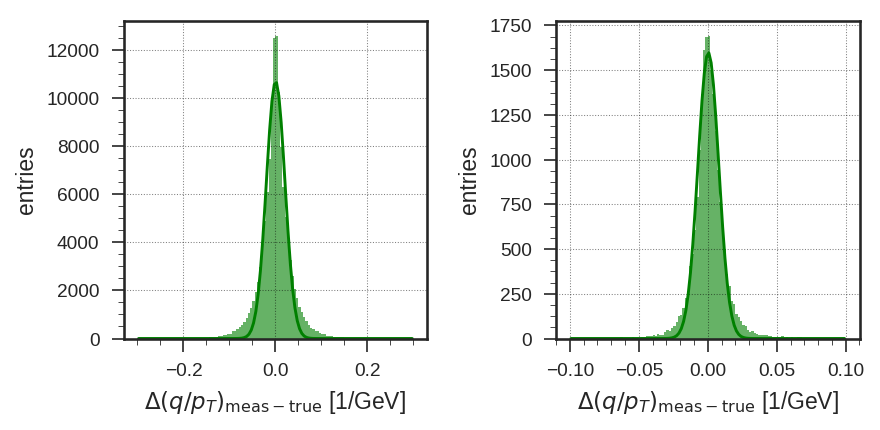

In [11]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 1.762518e-01, std: 1.195855e-01, mse: 9.170684e+02, mae: 3.003666e-01, mad: 1.333662e-01
[INFO    ] gaus fit (a, mu, sig): 9.310095e+03, -9.488434e-03, 1.211097e-01
[INFO    ] # of entries: 20086, mean: 9.248682e-01, std: 1.457969e-01, mse: 5.673561e+03, mae: 1.203797e+00, mad: 2.618315e-01
[INFO    ] gaus fit (a, mu, sig): 8.593701e+02, -8.066436e-02, 1.990610e-01


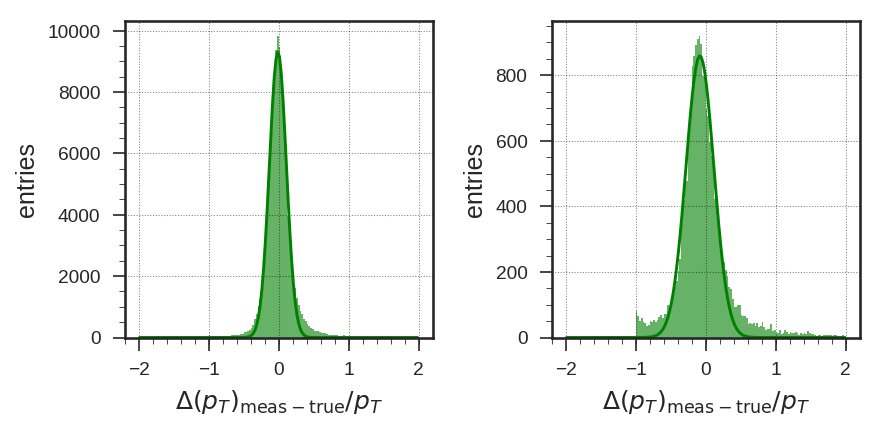

In [12]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

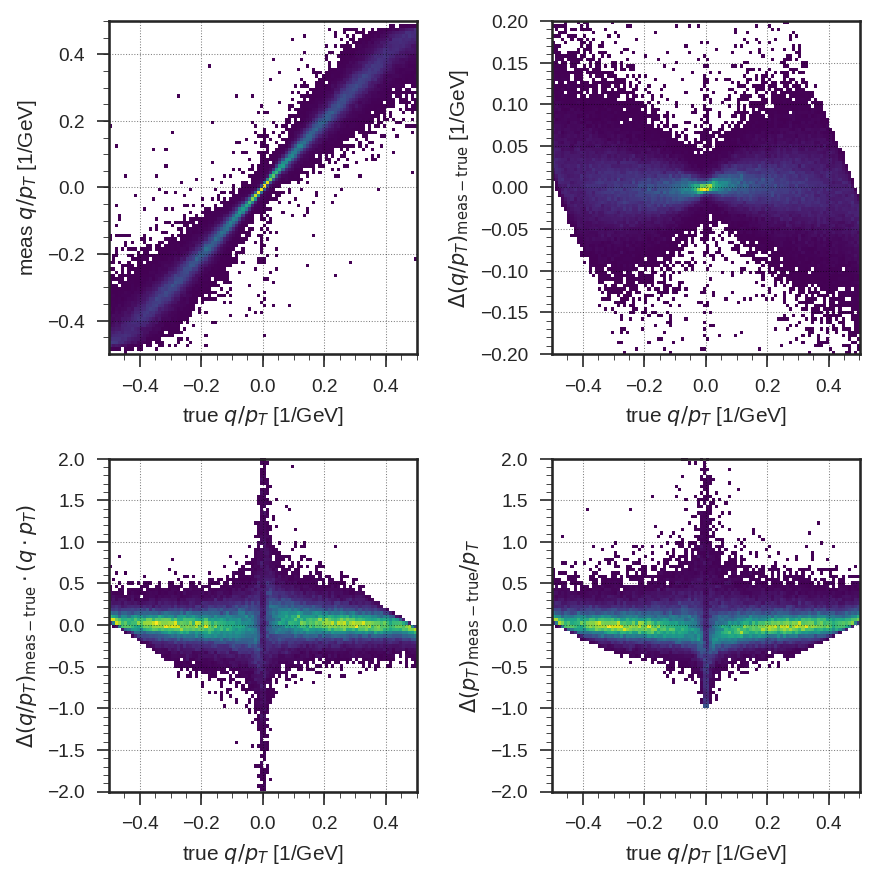

In [13]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_pred - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = np.abs(y_test_true/y_test_pred) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [14]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 8.395973e+01, -5.536391e-02, 1.502934e-01
[INFO    ] gaus fit (a, mu, sig): 7.783586e+01, -6.470531e-02, 1.659168e-01
[INFO    ] gaus fit (a, mu, sig): 7.067546e+01, -7.888807e-02, 1.748099e-01


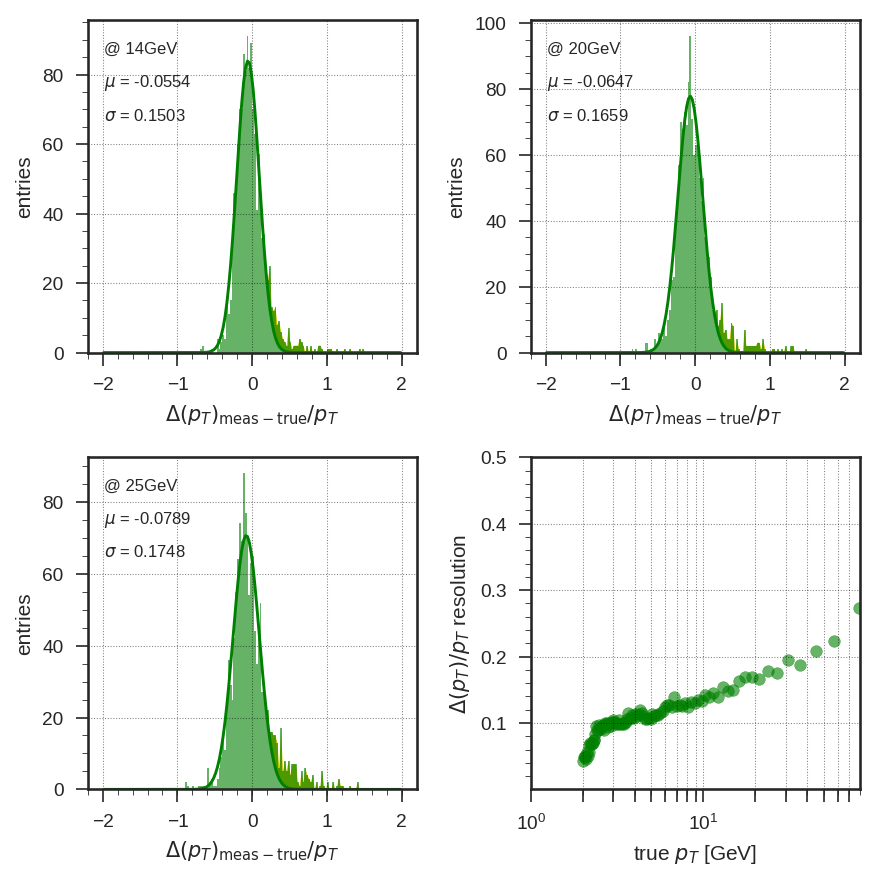

In [15]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] high tail prob: 7.696024e-02, 7.802949e-02, 1.104733e-01


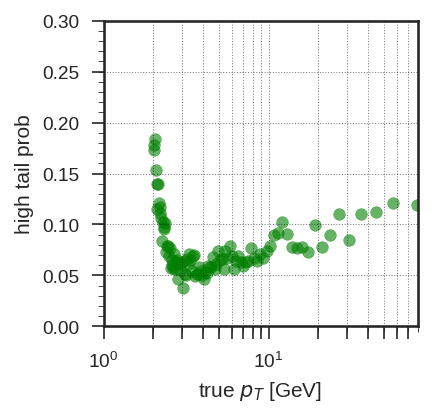

In [16]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'high tail prob', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] coverage # of sigmas: 1.518827e+00, 1.547957e+00, 1.639055e+00


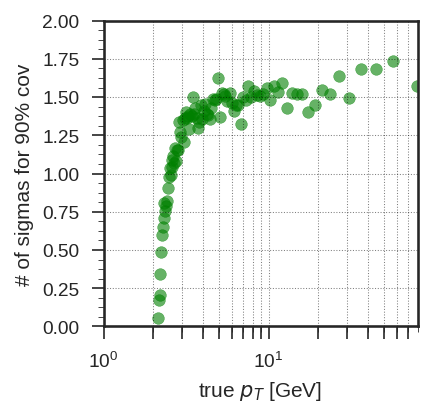

In [17]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
import scipy.special
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'# of sigmas for 90% cov', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

### Classification Results

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1-ikaegh/lib/python2.7/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1-ikaegh/lib/python2.7/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
[INFO    ] (190771, 20086), ll: nan, ss: 9.688661e-01
[INFO    ] auc: 0.99832699572
[INFO    ] thr: [0.9977, 0.9960, 0.9933, 0.9866, 0.9830, 0.9734, 0.9600, 0.9230, 0.2705]
[INFO    ] tpr: [0.9001, 0.9299, 0.9529, 0.9708, 0.9750, 0.9809, 0.9857, 0.9902, 0.9991]
[INFO    ] fpr: [0.0058, 0.0063, 0.0075, 0.0092, 0.0096, 0.0104, 0.0116, 0.0140, 0.0361]


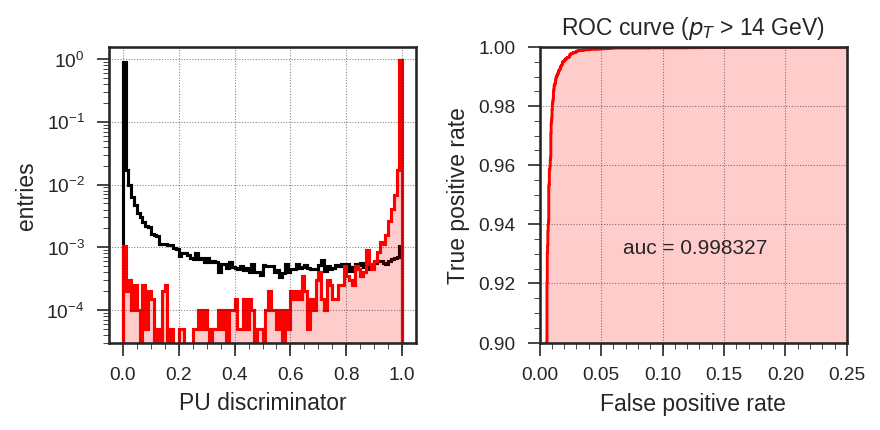

In [18]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
y_test_sel_high = np.abs(1.0/y_test_true) > discr_pt_cut_high
pu_y_test_sel_high = ~(pu_aux_test[:,2] > discr_pt_cut_high)  # veto PU events with high-pT tracks
if pu_y_test_sel_high.ndim == 1:
  pu_y_test_sel_high = pu_y_test_sel_high[:, np.newaxis]

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_high], np.zeros_like(pu_y_test_true)[pu_y_test_sel_high]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_high], pu_y_test_pred_discr[pu_y_test_sel_high]))
zz = np.concatenate((y_test_pred[y_test_sel_high], pu_y_test_pred[pu_y_test_sel_high]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1:e}, ss: {2:e}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > %.0f GeV)' % discr_pt_cut_high)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.25)
axs[1].set_ylim(0.9,1.0)

plt.show()

[INFO    ] (190009, 35286), ll: nan, ss: 9.626904e-01
[INFO    ] auc: 0.996860918008
[INFO    ] thr: [0.9857, 0.9796, 0.9691, 0.9515, 0.9428, 0.9251, 0.8932, 0.8066, 0.1231]
[INFO    ] tpr: [0.9004, 0.9261, 0.9514, 0.9710, 0.9751, 0.9803, 0.9852, 0.9905, 0.9990]
[INFO    ] fpr: [0.0105, 0.0131, 0.0176, 0.0240, 0.0247, 0.0271, 0.0310, 0.0355, 0.0769]


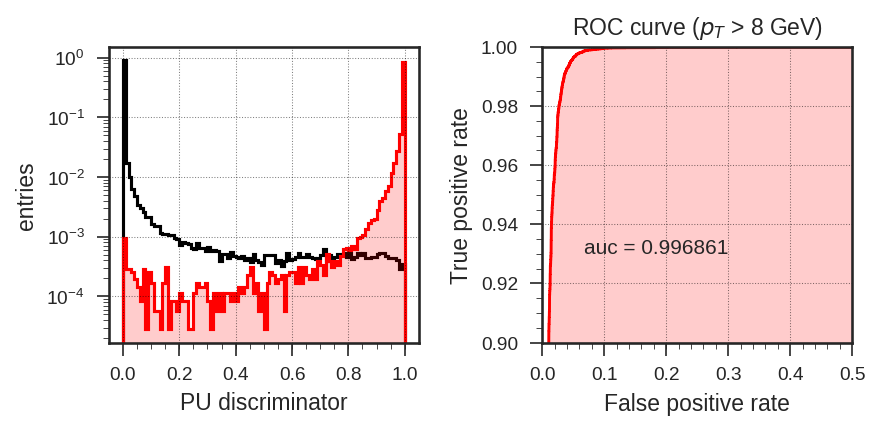

In [19]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
y_test_sel_med = np.abs(1.0/y_test_true) > discr_pt_cut_med
pu_y_test_sel_med = ~(pu_aux_test[:,2] > discr_pt_cut_med)  # veto PU events with high-pT tracks
if pu_y_test_sel_med.ndim == 1:
  pu_y_test_sel_med = pu_y_test_sel_med[:, np.newaxis]

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_med], np.zeros_like(pu_y_test_true)[pu_y_test_sel_med]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_med], pu_y_test_pred_discr[pu_y_test_sel_med]))
zz = np.concatenate((y_test_pred[y_test_sel_med], pu_y_test_pred[pu_y_test_sel_med]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1:e}, ss: {2:e}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_med
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > %.0f GeV)' % discr_pt_cut_med)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

[INFO    ] (182231, 70265), ll: nan, ss: 9.365754e-01
[INFO    ] auc: 0.988322729417
[INFO    ] thr: [0.7029, 0.6195, 0.5046, 0.3854, 0.3488, 0.3070, 0.2651, 0.1979, 0.0239]
[INFO    ] tpr: [0.9001, 0.9251, 0.9501, 0.9700, 0.9751, 0.9800, 0.9850, 0.9900, 0.9990]
[INFO    ] fpr: [0.0375, 0.0505, 0.0696, 0.0925, 0.1007, 0.1109, 0.1230, 0.1391, 0.2388]


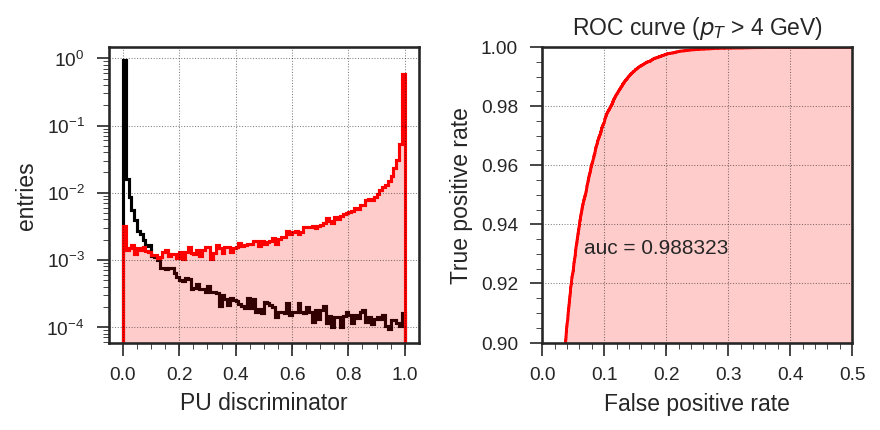

In [20]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 4 GeV, corresponding to 5 GeV trigger threshold
y_test_sel_low = np.abs(1.0/y_test_true) > discr_pt_cut_low
pu_y_test_sel_low = ~(pu_aux_test[:,2] > discr_pt_cut_low)  # veto PU events with high-pT tracks
if pu_y_test_sel_low.ndim == 1:
  pu_y_test_sel_low = pu_y_test_sel_low[:, np.newaxis]

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_low], np.zeros_like(pu_y_test_true)[pu_y_test_sel_low]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_low], pu_y_test_pred_discr[pu_y_test_sel_low]))
zz = np.concatenate((y_test_pred[y_test_sel_low], pu_y_test_pred[pu_y_test_sel_low]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1:e}, ss: {2:e}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_low
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > %.0f GeV)' % discr_pt_cut_low)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates

In [21]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  lut = np.array([1,3,5,7,9,7,5,3,1,0,2,4,6,8,6,4,2,0], dtype=np.int32)
  return lut[ipt]

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [22]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut_low = 4.
    self.discr_pt_cut_med = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 2.4605,  2.0075,  1.9042,  2.0762,  2.4325,  2.9043,  3.4101,  3.9232,
                  4.4403,  4.9856,  5.5775,  6.2036,  6.8515,  7.5126,  8.1807,  8.8570,
                  9.5343, 10.2031, 10.8651, 11.5340, 12.2164, 12.9187, 13.6537, 14.4093,
                 15.1559, 15.8731, 16.5513, 17.2402, 17.9719, 18.7379, 19.5292, 20.3469,
                 21.1514, 21.9302, 22.6964, 23.4417, 24.1086, 24.7471, 25.4113, 26.1038,
                 26.7868, 27.4820, 28.2311, 29.0478, 29.9305, 30.8285, 31.6537, 32.3950,
                 33.1279, 33.8928, 34.6529, 35.4154, 36.2441, 37.1817, 38.2494, 39.2588,
                 40.1019, 40.8765, 41.6557, 42.4564, 43.2505, 44.0659, 44.9429, 45.8573,
                 46.7469, 47.6586, 48.6987, 49.6689, 50.3389, 50.9753, 51.7242, 52.4922,
                 53.2630, 54.0344, 54.8061, 55.5778, 56.3496, 57.1213, 57.8931, 58.6648,
                 59.4366, 60.2083, 60.9800, 61.7518, 62.5235, 63.2953, 64.0670, 64.8387,
                 65.6104, 66.3822, 67.1539, 67.9256, 68.6974, 69.4691, 70.2408, 71.0125,
                 71.7843, 72.5560, 73.3277, 74.0995, 74.8712, 75.6429, 76.4146, 77.1864,
                 77.9581, 78.7298, 79.5015, 80.2733, 81.0450, 81.8167, 82.5884, 83.3602,
                 84.1319, 84.9036, 85.6754, 86.4471, 87.2188, 87.9905, 88.7623, 89.5340]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      x = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      binx = x.astype(np.int32)
      if binx == bins[0]-1:  # avoid boundary
        binx -= 1
      return binx

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    trg_pt = interpolate(xml_pt, x0, x1, y0, y1)
    assert(trg_pt > 2.)
    return trg_pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg.astype(np.int32)
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)
    strg_ok = (quality2 <= (quality1+1))

    xml_pt = np.abs(1.0/y_pred)

    # Apply cuts
    trigger = (y_discr < 0.)  # default: False
    if self.omtf_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.0% coverage)
        trigger = (y_discr > 0.6043)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.0% coverage)
        trigger = (y_discr > 0.2905)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (98.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    elif self.run2_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (97.0% coverage)
        trigger = (y_discr > 0.8557)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (97.0% coverage)
        trigger = (y_discr > 0.6640)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (97.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    else:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.5% coverage)
        trigger = (y_discr > 0.9600)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.5% coverage)
        trigger = (y_discr > 0.8932)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (99.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (4,))

      y_pred = np.asscalar(y[...,0])
      y_discr = np.asscalar(y[...,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, phi_median, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)

      if passed:
        xml_pt = np.abs(1.0/y_pred)
        pt = self.get_trigger_pt(y_pred)

        trk_q = np.sign(y_pred).astype(np.int32)
        trk = Track(myroad.id, myroad.hits, mode, myroad.quality, zone, xml_pt, pt, trk_q, y_pred, y_discr, phi_median, theta_median)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [23]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred, y_test_pred_discr, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  true_pt = np.abs(1.0/y_true)
  
  eff_data.append((zone, true_pt, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(true_pt), float(xml_pt), float(pt), passed

eff_data = np.asarray(eff_data)

0 6 0.999747335911 26.4465675354 28.5612106323 40.9718906494 [ True]
1 6 0.999483942986 4.25680494308 6.12963294983 7.02290068626 [ True]
2 6 0.995402336121 12.298915863 10.7510318756 13.2877168571 [ True]
3 8 0.00173951417673 2.83806705475 3.07353544235 3.48556207094 [False]
4 7 0.0008288208046 2.08398747444 2.19945836067 2.62070890913 [ True]
5 8 0.624630987644 3.28855633736 2.9795935154 3.38945680017 [ True]
6 7 0.999906420708 204.229217529 228.739151001 350.737705655 [ True]
7 8 0.00189015746582 2.34633588791 2.27642321587 2.69333294649 [ True]
8 7 0.802177786827 3.22838068008 2.68361663818 3.09004659119 [ True]
9 4 0.995749354362 4.21332979202 3.93783211708 4.37600597548 [ True]
10 6 0.470025539398 4.78337335587 4.76487398148 5.29915781927 [ True]
11 8 0.153880566359 3.92263269424 3.82605791092 4.26040909147 [False]
12 2 5.7292450947e-05 2.17857146263 2.19638347626 2.6178074482 [ True]
13 9 0.990521430969 16.017742157 14.4711313248 18.6936731895 [ True]
14 4 0.977952003479 3.72855

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


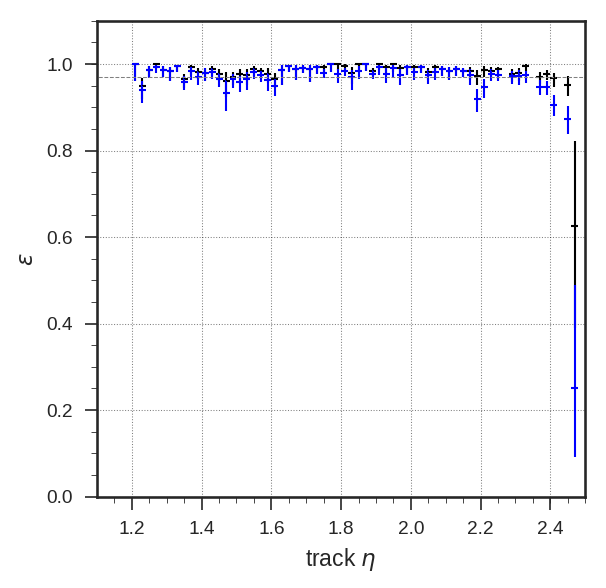

In [24]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is true_pt
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))

# Efficiency for (L1 pT > 20) only
color = 'black'
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

plt.plot([xlow-0.5,xup+0.5], [0.97,0.97], ls='dashed', lw=0.5, color='gray')
#plt.xlim(xlow-0.5,xup+0.5)
plt.xlim(1.1,2.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


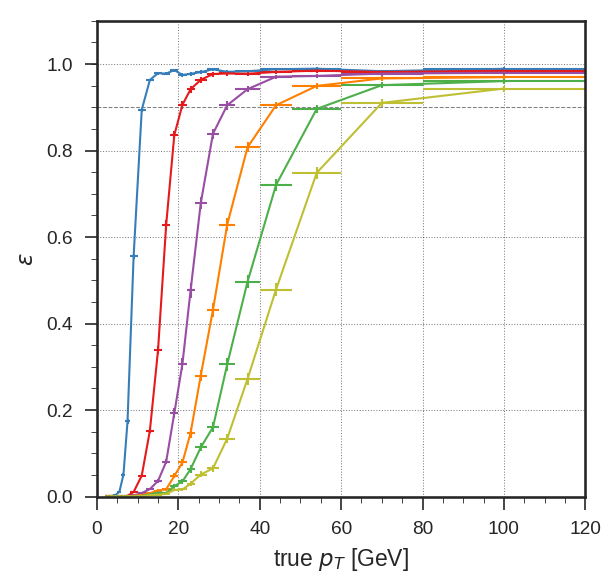

In [25]:
# Efficiency vs pT
plt.figure()

eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is true_pt

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is true_pt
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  #print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [26]:
# Find out pT scale factor

xmin = 0.
xmax = 60.
nbinsx = 120
xedges = np.linspace(xmin, xmax, num=nbinsx+1)  # edges used to digitize true_pt

nbinsy = 5  # j = zone0-1, zone2-4, zone5, zone6, all zones

# Each bin contains the threshold for ~90% probability for (zone_special, true_pt)
xxx = np.zeros((nbinsy,nbinsx), dtype=np.float32)

for j in xrange(nbinsy):
  if j == 0:
    sel_j = (0 <= eff_data[:,0]) & (eff_data[:,0] <= 1)
  elif j == 1:
    sel_j = (2 <= eff_data[:,0]) & (eff_data[:,0] <= 4)
  elif j == 2:
    sel_j = (eff_data[:,0] == 5)
  elif j == 3:
    sel_j = (eff_data[:,0] == 6)
  elif j == 4:
    sel_j = (eff_data[:,0] >= 0)

  xx = eff_data[:,1][sel_j]  # true_pt
  yy = eff_data[:,2][sel_j]  # xml_pt
  zz = eff_data[:,4][sel_j]  # discr_passed

  ind = np.digitize(xx, xedges[1:])  # split into mutually-exclusive true_pt bins

  for i in xrange(nbinsx):
    # >>> xedges[:5]
    # array([0. , 0.5, 1. , 1.5, 2. ])
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue

    if 0 <= xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 40:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size

    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90.
    coverage += 0.5 # inefficiency due to fiducial cuts
    #coverage += 1.0 # inefficiency due to fiducial cuts

    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue

    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    xxx[j,i] = pct

    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

14.0 1.98632367307
14.5 1.98606271777
15.0 2.0325203252
15.5 1.82595182595
16.0 1.86519711742
16.5 1.75438596491
17.0 1.56918687589
17.5 1.45509282489
18.0 1.61964472309
18.5 1.54355016538
19.0 1.54028436019
19.5 2.07317073171
20.0 2.37179487179
20.5 2.53521126761
21.0 2.33236151603
21.5 2.47005988024
22.0 1.93081255028
22.5 1.84718723762
23.0 1.66083916084
23.5 1.71635049684
24.0 1.81644359465
24.5 1.80586907449
25.0 1.83106910809
25.5 1.8018018018
26.0 1.99501246883
26.5 1.84361093452
27.0 1.50720838794
27.5 1.52354570637
28.0 1.57593123209
28.5 1.91036002939
29.0 1.76787086856
29.5 1.6548463357
30.0 1.75159235669


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

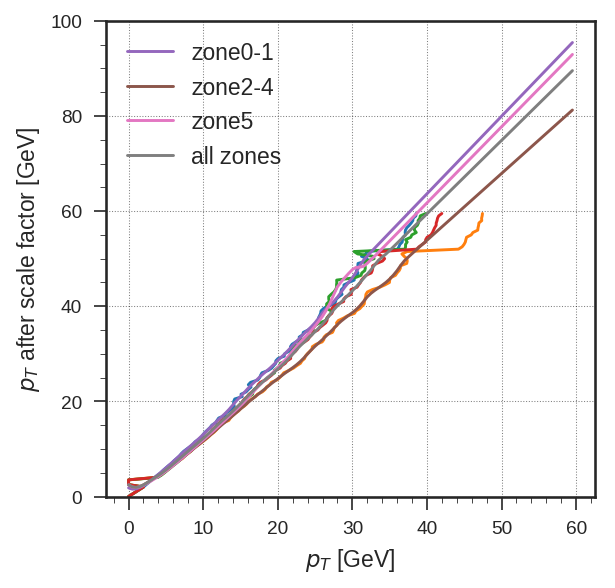

In [27]:
plt.figure()

# Before smoothing
xdata = xedges[:-1]
if omtf_input:
  #plt.plot(xxx[0], xdata)
  #plt.plot(xxx[1], xdata)
  #plt.plot(xxx[2], xdata)
  plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
else:
  plt.plot(xxx[0], xdata)
  plt.plot(xxx[1], xdata)
  plt.plot(xxx[2], xdata)
  #plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')

# After smoothing
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if omtf_input:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')
else:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[4:]))

plt.ylim(0,100)
plt.show()

In [28]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for jevt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred, pu_y_test_pred_discr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  #true_pt = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  highest_part_pt = highest_part_pt if highest_part_pt > 0 else np.nan
  highest_track_pt = highest_track_pt if highest_track_pt > 0 else np.nan
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  if passed and highest_part_pt < 14 and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt),
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2937 11.6057 18.0000 7 [39.32463503] [0.9952968]
  33 7005 13.7175 22.0000 7 [23.55974006] [0.99920243]
  34 5704 11.0421 18.0000 7 [21.01795551] [0.9991866]
  36 5457 12.4612 27.0000 6 [22.13165252] [0.9999052]
  37   78 11.6820 21.0000 7 [21.30976012] [0.99904114]
  39  107  7.8551 48.0000 7 [30.88396264] [0.997689]
  39 5201 11.1191 23.0000 7 [22.97861118] [0.9995351]
  41 5070  5.4455 20.5000 7 [23.73961002] [0.99326915]
  42 6076  4.2953     nan 7 [31.55414489] [0.9838721]
  44 7189 11.7123 19.0000 8 [21.69673588] [0.99942976]
  44 7462 11.4250 18.0000 6 [34.60619693] [0.9966557]
  44 7502  7.2048 19.5000 7 [31.74368171] [0.9950316]
  48  955  4.3946 24.5000 5 [25.76181367] [0.9992273]
  49 4772  4.8699     nan 7 [21.04098012] [0.99847394]
  50 4726 11.9545     nan 6 [23.04962883] [0.98298806]
  52  548 11.7123 23.5000 8 [22.35481867] [0.9995665]
  53 6612 12.3604 20.5000 7 [20.73672086] [0.9725949]
  54 6419  7.5854 41.5000 8 [544.73620422] [0.9998497]
.... 0 [-38.  46.]
...

[INFO    ] nevents: 258400/498400


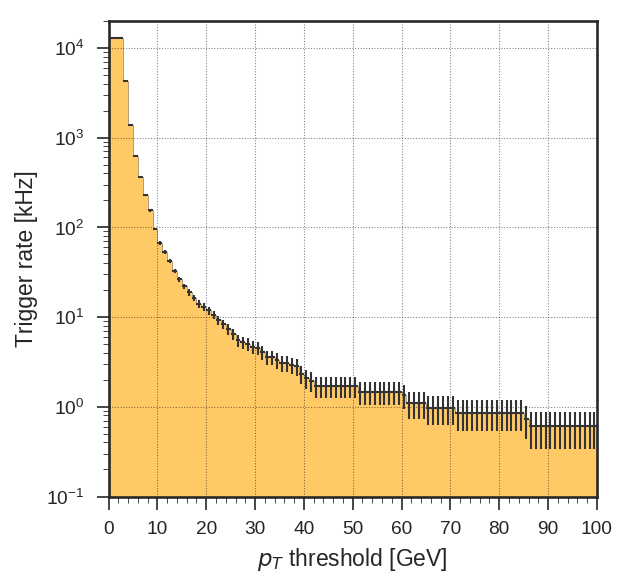

[INFO    ] Rates at 18/20/22/25 GeV: 14.05401849, 11.8542590067, 9.16566418856, 6.47706937045


[1.2879e+04, 1.2879e+04, 1.2879e+04, 4.2422e+03, 1.3642e+03, 6.1605e+02,
 3.6455e+02, 2.3159e+02, 1.5411e+02, 9.5812e+01, 6.6970e+01, 5.2672e+01,
 4.2162e+01, 3.2752e+01, 2.6397e+01, 2.1998e+01, 1.8820e+01, 1.6376e+01,
 1.4054e+01, 1.2954e+01, 1.1854e+01, 1.0632e+01, 9.1657e+00, 8.3102e+00,
 7.3325e+00, 6.4771e+00, 5.4994e+00, 5.2550e+00, 5.0106e+00, 4.6439e+00,
 4.5217e+00, 4.0329e+00, 3.5441e+00, 3.5441e+00, 3.2996e+00, 3.0552e+00,
 3.0552e+00, 2.9330e+00, 2.8108e+00, 2.3220e+00, 2.0776e+00, 1.9553e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.3443e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > 1e-7]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

logger.info("Rates at 18/20/22/25 GeV: {0}, {1}, {2}, {3}".format(hist[18], hist[20], hist[22], hist[25]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

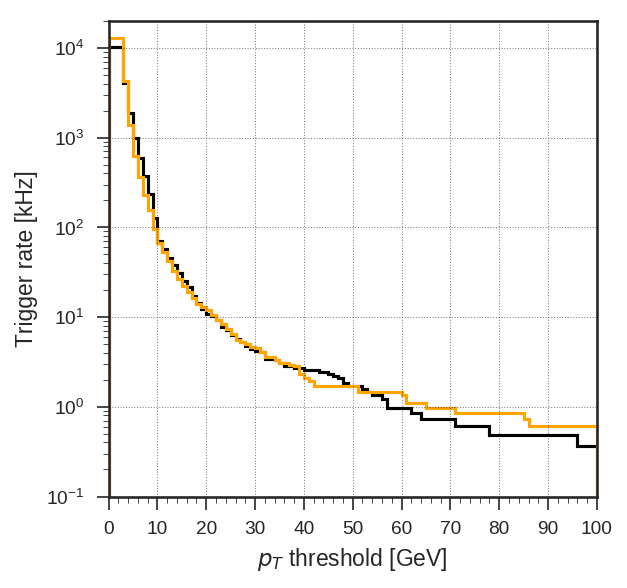

In [30]:
# Old rates
old_hist = [1.0308e+04, 1.0308e+04, 1.0308e+04, 4.0897e+03, 1.8846e+03, 9.9760e+02,
 5.9589e+02, 3.7664e+02, 2.3440e+02, 1.2795e+02, 7.0148e+01, 5.7560e+01,
 4.5217e+01, 3.8007e+01, 3.0797e+01, 2.5542e+01, 2.1509e+01, 1.7354e+01,
 1.4421e+01, 1.2343e+01, 1.0877e+01, 1.0143e+01, 9.2878e+00, 7.8213e+00,
 7.0881e+00, 6.2326e+00, 5.6216e+00, 5.2550e+00, 4.7661e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.8108e+00, 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00, 2.1998e+00, 2.0775e+00,
 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.4665e+00,
 1.3443e+00, 1.3443e+00, 1.2221e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

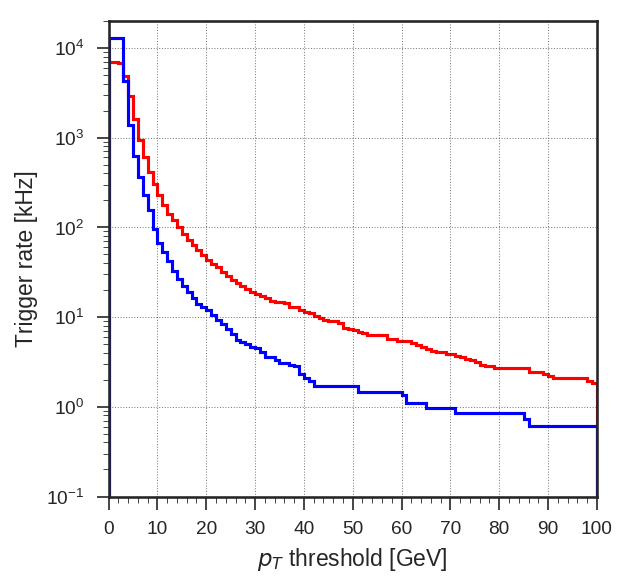

In [31]:
# Reference EMTF rates
old_hist = [7.0348e+03, 7.0348e+03, 6.7679e+03, 4.9052e+03, 2.8801e+03, 1.5997e+03,
 9.3649e+02, 6.0726e+02, 4.1551e+02, 3.0552e+02, 2.2865e+02, 1.7781e+02,
 1.4237e+02, 1.1940e+02, 9.9600e+01, 8.4569e+01, 7.1859e+01, 6.3182e+01,
 5.6338e+01, 4.9617e+01, 4.3262e+01, 3.9473e+01, 3.5929e+01, 3.2141e+01,
 2.8352e+01, 2.6153e+01, 2.4197e+01, 2.2242e+01, 2.0776e+01, 1.8820e+01,
 1.8209e+01, 1.7231e+01, 1.6254e+01, 1.5154e+01, 1.4665e+01, 1.4543e+01,
 1.4176e+01, 1.3076e+01, 1.2832e+01, 1.1854e+01, 1.1365e+01, 1.0999e+01,
 1.0143e+01, 9.7767e+00, 9.2879e+00, 9.0435e+00, 8.9212e+00, 8.6768e+00,
 7.5769e+00, 7.3325e+00, 7.2103e+00, 6.8437e+00, 6.7215e+00, 6.3549e+00,
 6.3549e+00, 6.2327e+00, 6.2327e+00, 5.7438e+00, 5.7438e+00, 5.3772e+00,
 5.3772e+00, 5.3772e+00, 5.1328e+00, 4.8884e+00, 4.6439e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 4.0329e+00, 3.9107e+00, 3.9107e+00, 3.6663e+00,
 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00, 2.9330e+00, 2.8108e+00,
 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00,
 2.6886e+00, 2.6886e+00, 2.4442e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00,
 2.1998e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00,
 2.0776e+00, 2.0776e+00, 1.9553e+00, 1.8331e+00]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='red', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='blue', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

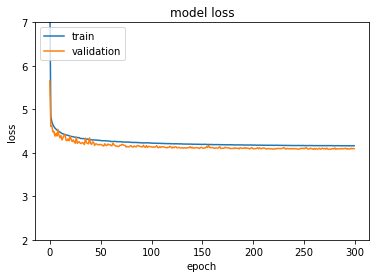

In [32]:
# Training history
# 2019-06-27

"""
[INFO    ] Done training. Time elapsed: 2:45:42.233456 sec
[INFO    ] Epoch 300/300 - loss: 4.16373185956 - regr_loss: 3.32120957551 - discr_loss: 0.0421261143613 - val_loss: 4.09427099966 - val_regr_loss: 3.26545494275 - val_discr_loss: 0.0414408028216
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XmcFdWd9/HP7269NzTQ7MjiRssiICIGMSrGuMZdTNSJZhISJ4n6mkzmwewzT8zkmSRq4hgTTcyYxCUGQzSJ0YgBl6goICKrC4IsAs3SdDe93eU8f5zqpsFegdvLvd/368Wr71K36lQV91unTp0615xziIhI5gt1dwFERKRrKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfBDCz/zWz73Zw2g1mdvbhzkekqynwRUSyhAJfRCRLKPCl1wiaUr5qZm+aWbWZ3W9mg8zsr2ZWaWYLzKyk2fSfMLNVZlZhZovMrKzZe5PNbJmZVZnZ74Dcg5Z1oZktDz77kplNPMQyf87M3jGz3Wb2hJkNDV43M7vDzHYEZX/TzMYH751vZquDsm0xs387rA0nElDgS29zOXA2cDxwIfAU8DVgYPD/+SZ8aB4HPAzcApQCTwJ/MrOYmcWAPwK/AfoBvw/mS/DZycD9wOeB/sDPgSfMLKczBTWzs4D/Aq4ChgAbgUeCt88BTgeOA/oE0+wK3vsl8HnnXBEwHvj7kdyAkr0U+NLb3OWc2+6c2wK8ALzinHvdOVcHzAcmB9PNBv7inHvGORcHfgjkAR8BpgNR4E7nXNw5Nw94rdky5gA/d84tds4lnXMPAPXB5zrjGuB+59wy51w9cCtwqpmNAuJAETAWMOfcGufcB8Hn4sAJZlbsnNvjnFt2hLadZDkFvvQ225s9rm3heWHweGhQowbAOZcCNgHDgve2uANHDtzY7PFI4CtBc06FmVUAI4LPdcbBZagOavHDnHN/B/4HuBvYYWb3mllxMOnlwPnARjN7zsxO7eRyRVqkwJdMtTUIbgjazIPQ3gJ8AAwLXmt0VLPHm4DbnHN9m/3Ld849fJhlKAiaiLbgDwA/cc6dBJwQNO18NXj9NefcxUEz1R+BRw9jO4g0UeBLpnoUuMDMZplZFPhK0CzzEvAykABuMrOomV0GTGv22fuAL5jZKcHF1QIzu8DMijpZhoeBG8xsUtD+/z1gsXNug5mdHMw/CuwD6oBUcI3hGjPrEzRFVQKpI7xtJEsp8CUjOefWAdcCdwE7gYuAi5xzDc65BuAy4Hpgd9De/4dmn10CfC5octkDvBNM29kyLAC+CTwWnFUcDVwdvF0cHFj2BM0+u4AfBO9dB2wws0rgC8G1AJHDZvoBFBGR7KAavohIlkhb4JvZ8cGNK43/Ks3slnQtT0RE2tYlTTpmFg56JpzinNvYgY+IiMgR1lVNOrOAdxX2IiLdJ9JFy7k66KL2IWY2J7izkYKCgpPGjh3b6Zlv2LmPRMpxzMDCDkwtIpI5li5dutM5V9qRadPepBOMW7IVGOec297WtFOnTnVLlizp9DI+87+vUV5Vz5++fNrhFFVEpNcxs6XOuakdmbYrmnTOA5a1F/aHI2SQUvdSEZE2dUXgf7K15pwjxcxIKe9FRNqU1sAPxg75WPO7GNMhZKAbyERE2pbWi7bOuX3BYFGHLB6Ps3nzZurq6lqd5rqxURKpItasWXM4i8oKubm5DB8+nGg02t1FEZEu1lW9dA7Z5s2bKSoqYtSoURw4uOF+G3ftoy6e4vjBnR3bKrs459i1axebN29m9OjR3V0cEeliPX5ohbq6Ovr3799q2AO0/o40Z2b079+/zbMlEclcPT7wCYKqnSkAteF3RPvbUkQyVa8I/PaYKe5FRNqTEYEP6avgV1RU8NOf/rTTnzv//POpqKhIS5lERA5F5gR+mrQW+IlEos3PPfnkk/Tt2zeNJRMR6Zwe30unI9LZgj937lzeffddJk2aRDQaJTc3l5KSEtauXctbb73FJZdcwqZNm6irq+Pmm29mzpw5AIwaNYolS5ZQXV3Neeedx2mnncZLL73EsGHDePzxx8nLy0tTiUVEWtarAv8//rSK1VsrP/R6fSJFMuXIj4U7Pc8Thhbz7YvGtfr+97//fVauXMny5ctZtGgRF1xwAStXrmzq1nj//ffTr18/amtrOfnkk7n88svp3//AWw/efvttHn74Ye677z6uuuoqHnvsMa699tpOl1VE5HD0qsDvCaZNm3ZAH/af/OQnzJ8/H4BNmzbx9ttvfyjwR48ezaRJkwA46aST2LBhQxeXWkSklwV+azXxLXtq2Fub4IShxWkvQ0FBQdPjRYsWsWDBAl5++WXy8/M544wzWuzjnpOT0/Q4HA5TW1ub9nKKiBwsQy7apq9veVFREVVVVS2+t3fvXkpKSsjPz2ft2rW88soraSuHiMjh6lU1/FYZuDRdtu3fvz8zZsxg/Pjx5OXlMWjQoKb3zj33XH72s59RVlbG8ccfz/Tp09NSBhGRI6FLftO2o1r6AZQ1a9ZQVlbW5ue2VtSyp6aBcUP7pLmEmaEj21REeoee9gMoXaPnHLdERHqkjAh8jaQjItK+jAh8DZcpItK+zAh81fBFRNqVEYGvCr6ISPsyIvCDfpkiItKGDAn89PXD76zCwkIAtm7dyhVXXNHiNGeccQYHdz892J133klNTU3Tcw23LCKHKyMCv/FHnHrSPQVDhw5l3rx5h/z5gwNfwy2LyOHKiMBPp7lz53L33Xc3Pf/Od77Dd7/7XWbNmsWUKVOYMGECjz/++Ic+t2HDBsaPHw9AbW0tV199NWVlZVx66aUHjKVz4403MnXqVMaNG8e3v/1tCAZk27p1K2eeeSZnnnkmBMMt79y5E4Dbb7+d8ePHM378eO68886m5ZWVlfG5z32OcePGcc4552jMHhE5QO8aWuGvc2Hbmx96uSSZoiCRgpxw5y/hDp4A532/1bdnz57NLbfcwhe/+EUAHn30UZ5++mluuukmiouL2blzJ9OnT+cTn/hEq78Xe88995Cfn8+aNWtYsWIFU6ZMaXrvtttuo1+/fiSTSWbNmsWKFSu46aabuP3221m4cCEDBgw4YF5Lly7lV7/6FYsXL8Y5xymnnMJHP/pRSkpKNAyziLRJNfx2TJ48mR07drB161beeOMNSkpKGDx4MF/72teYOHEiZ599Nlu2bGH79u2tzuP5559vCt6JEycyceLEpvceffRRpkyZwuTJk1m1ahWrV69uszwvvvgil156KQUFBRQWFnLZZZfxwgsvgIZhFpF29K4afis18YqqOrbtrWP80D5Y6Mh30rzyyiuZN28e27ZtY/bs2Tz44IOUl5ezdOlSotEoo0aNanFY5Pa89957/PCHP+S1116jpKSE66+//pDm00jDMItIWzKiht8Y8em6ZDt79mweeeQR5s2bx5VXXsnevXsZOHAg0WiUhQsXsnHjxjY/f/rpp/PQQw8BsHLlSlasWAFAZWUlBQUF9OnTh+3bt/PXv/616TOtDcs8c+ZM/vjHP1JTU8O+ffuYP38+M2fOPOLrLCKZp3fV8FuV3luvxo0bR1VVFcOGDWPIkCFcc801XHTRRUyYMIGpU6cyduzYNj9/4403csMNN1BWVkZZWRknnXQSACeeeCKTJ09m7NixjBgxghkzZjR9Zs6cOZx77rkMHTqUhQsXNr0+ZcoUrr/+eqZNmwbAZz/7WSZPnqzmGxFpV0YMj1xeVc8He2sZN7SYcCgjTlrSSsMji2SOrBseualJp+ccu0REepyMCHwNpiMi0r5eEfjtNTul+6JtJulJTXgi0rV6fODn5uaya9cuBdUR4Jxj165d5ObmdndRRKQb9PheOsOHD2fz5s2Ul5e3Os2++gR7auKE9uYSTkM//EySm5vL8OHDu7sYItINenzgR6NRRo8e3eY0j7z6PnOfeJOXbz2LIX3yuqpoIiK9So9v0umIUDCGTUqtPiIirUpr4JtZXzObZ2ZrzWyNmZ2anuX4vyklvohIq9LdpPNj4Cnn3BVmFgPy07GQxhq+ruuKiLQubYFvZn2A04Hr8T1EGoCGdCyr8ebalBJfRKRV6WzSGQ2UA78ys9fN7BdmVnDwRGY2x8yWmNmStnritKWxhp9U4IuItCqdgR8BpgD3OOcmA/uAuQdP5Jy71zk31Tk3tbS09JAWtL9JR4EvItKadAb+ZmCzc25x8HxecAA44tRLR0SkfWkLfOfcNmCTmR0fvDQLaPvnnA5R471WasMXEWldunvpfBl4MOihsx64IR0Lafwt2VQqHXMXEckMaQ1859xyoEPjNB8O1fBFRNqXUXfaKu9FRFqXGYGvfvgiIu3KiMBvasNX4IuItCojAj+kwBcRaVdGBH5Y/fBFRNqVEYEf0miZIiLtyojAN9XwRUTalRGB31jD11g6IiKty4jAP+aFm7ks9Lxq+CIibciIwO+76e+Uhd5XLx0RkTZkROC7cJQoCQW+iEgbMiPwQ1FiCnwRkTZlTOBHSWi0TBGRNmRG4IejRCypGr6ISBsyIvAJxYI2/O4uiIhIz5URge/Cvg1f/fBFRFqXEYFPYxu+8l5EpFUZEfguHCWC2vBFRNqSEYFPOErM1C1TRKQtGRH4Lrhoq7wXEWldRgQ+wZ22STXii4i0KmMCX234IiJty5DAjwXdMru7ICIiPVeGBL4GTxMRaU9GBL6FokQtqX74IiJtyIjAd5EYEdXwRUTalBGBb01t+Ap8EZHWZETgE44RRU06IiJtiXR3AY4EC0fUpCMi0o7MqeFbkmRSv4AiItKajAh8C8f831Siu4siItJjZUbgR3zgk2zo7qKIiPRYmRH44aj/m4p3d1FERHqsjAh8Gmv4CnwRkValtZeOmW0AqoAkkHDOTU3LcoI2/JCadEREWtUV3TLPdM7tTOcCQhFdtBURaU9GNOk0tuGTUg1fRKQ16Q58Bywws6VmNqelCcxsjpktMbMl5eXlh7QQdcsUEWlfugP/NOfcJOA84ItmdvrBEzjn7nXOTXXOTS0tLT20pTQGvtrwRURaldbAd85tCf7uAOYD09KyIHXLFBFpV9oC38wKzKyo8TFwDrAyLQsLAj+kwBcRaVU6e+kMAuabWeNyHnLOPZWWJTW14SvwRURak7bAd86tB05M1/wPoBq+iEi7MqJbpmr4IiLty4zAD/kafl1dXXeXRESkx8qMwA+adLbvqe7ukoiI9FgZEvi+SWd3ZRUNCf0IiohISzIq8EMuwbvlquWLiLQkQwLfN+lESbB6a2V3l0ZEpEfKqMDPC6dYsbmiu0sjItIjZUjg+yadY/vn8NSqbSRTrrtLJCLS42RG4AfdMscNzmN7ZT2L39vV3SUSEelxMiTwQ2BhxpTEKIiFeWjx+91dIhGRHqdDgW9mN5tZsXm/NLNlZnZO+ovXCS5J9KXbuXvUC/x5xQes3LK3u0skItKjdLSG/xnnXGUw4mUJcB3w/TSXrXP6HQ3Aaakl9CuI8a3HV6otX0SkmY4GvgV/zwd+45xb1ey1nuELL8KEK4lUbuKbF5ax7P0Kfvbcu91dKhGRHqOjgb/UzP4WBP7TwTj3PeuW1lg+DDwBKrdwSVkRF04cwg+eXsfdC9+Bivehekd3l1BEpFt1dHjkfwYmAeudczVm1g+4Ic1l67zSsQBY+VvcMfskwiHjB0+v47JXv83Ao44j/MmHuruEIiLdpqM1/FOBdc65CjO7FvgG0POuipYe7/++9BOilZu4/apJfObU4fSvWc+utxazdpvuwhWR7NXRwL8HqDGzE4GvAO8Cv05z2TqvZJT/u+YJePprhEPGt04rJGZJBrqdfOquZ7jv+fWkdDFXRLJQRwM/4ZxzwMXA/zjn7gaK0ly2zguF4bJf+OvJW1+Hhn2wff/P6F41sprbnlzDJ+97hXd2aJA1EckuHW3DrzKzW4PumDPNLARE01y2QzPxSti3A57+Gtw9Hfbuvwnr/0xOMmbyRP7vn1dz9u3PMX5YMRdNGMJFE0oZ2r9PtxZbRCTdOlrDnw3UB/3xtwHDgR+kuWyHbthJ/m+zsCdWhJWv4apjYeHnj+UbF5QxKrWJKxaewTs/voBLf/oP/vuptbz0zk7iyZ7VAUlE5Egw31LTgQnNBgEnB09fdc4d8X6OU6dOdUuWLDn8GTXUwH8Nh1gh1AfXlkee5mv+LgUFA+GGJ+Gej8CO1QBcUfonlm+pJpFynFq4g0+PTZEz/iKOGVjI8JI8zHrWbQciIvhsXuqcm9qRaTvUpGNmVwU1+kXBDVd3mdlXnXPzDru06RDLh8nXwMBx0FDtL+Ym6uHxf/HvV7wPbz3tw37UTNjwAvNmD2Ff0WheeLuckiduYNKbrzF1STFV5DOwKIeTR/Xj7KKNTKxYwO6Z/8nI/gUU50XJjYa7e21FRDqko234XwdObqzVm1kpsADomYEP8Im7DnzeUANP3wp1eyHZAH/5iq/pz/oW/PJjsH0VBQOO5dxxg3F/fRdrSPDEOVW8mD+NpRt289qGPUyv/i1HRxbwydWnsoMS8mNhbj1vLGNKCxlQmIMZHJ23j/A/7oCz/wOiuVC5FR77HFz+Cyge0l1bQ0Skw4EfOqgJZ1evG2kzlg+X3Qe1FTB/DlRuhjO/DoMngIVg+yqo2QVvPYXt86s6esezjL76M1w3fSQAiV/+ADbBvecV8mZsHI8v38o3H191wGL+OefvfNN+wY83jmRZbCpzil9hxsYX2b78KQbOvF5NQyLSbToa+E+Z2dPAw8Hz2cCTaSxXehz3cf934XehajtM/QxE86DfGFj7F9i5DlIJP83I0+Dtv8HLd8OWZXDZvUR2vQXApNwdTDplFFdPO4pVWyupbUiys7qeeDLFkJfnQzmU7FnBe+EyVq1/hRkReOJvf+OOBUMYUZJPTTxB37wYg4pzyImEiYaNcUP7MLhPLvmxcNPj2oYkZqjZSESOiA4FvnPuq2Z2OTAjeOle59z89BYtjU7/qm/TLxjgnw8/Gd54GPL6Qe1u/9qFd8Dd03z3zsZpanb6xzvXARANh5g0ou+B8161C8rhn0bs5NpPnUHtr+6ETXDRoJ1sGTmCzXtqKMiJUFETZ0tFHQ2JJHXxFH9cvvWA2URCRiK4Qax/QYxoOER+TpjSwhyKciNMH9OfowcWEg2FMIMP9taRHwtz3KAiSgtzmoa2y4mEyImEdGYhIh3vpdMVjlgvnc5K1MO2lf4AULsH9m6Gsgvh99fD2ieheCjsec9Pa2EoGgJDJsKud+DTf4acQnj/FRhzJvx4Iuzd5A8e/74e7hgHlVv88y8tgSe+DP2PhjNu9c1MgfKqeipqGqisi7N80152VtdTlBvBOdi0u4ZkylHTkGRHVR17auKdunGsKCfCyAH5/jqDvwYT/AUwCnPCjB1STEl+lPpEirIhxWytqCU3GqYwJ0JhToQ+eVH65kcpyo0SDrV88HDO6cAi0sU600unzcA3syqgpQnMf79d8eEU9GDdFvitiddC1TYf9r+51L82dApsXQa5ffz7R58FiTpYvwhGTIdNr0Dfo3xPoBk3wz9+DMXD/TWDKZ+GZQ/4+Xz8e3DqFw+5aG9u3kttPEnR+8+SyOtP0ZhTqK5PsG5bFRW18abp6uJJdlTW8d6uGipqGnAOHM7/DfZsRU0DW/fWdWi5ZlCcG6VPXpRYJMSOyjr65EeprE1QXZ/gmNJCImEj5eDE4X2amqQaEinyY2H65scozo1Q05AkFgnRJy9KcW6U6voE+bEwQ/vmEYuEiCdTFOdGSaYcSefIj4XpX5BDNGxBOYxEMoWZtXoAEskGRyzwu1qPC/zmXroLVj8BU67ztfTPPw/rn4Nnvunfn3wtvP5b//jin8K6J2Htn/3zj86F54Lfizn2477G71KQVwJ1lfDRr8KA4/0ZxpZlMOREKBrkDyj3fxwmzobp/wILvwd9R8CwqdBvtO9t9MPj/Y+4f+EFKBnZctnL3/L3IIyc0Vit/5CKmgYqauIkneOdHdWMGVBAfSLFvnof5Htr41TUxKmojbO3poGK2ji1DUkGFedSVRenOC9KXjTM2zuqMSCecry+cQ850RC1DUlyomFqGhLUxQ/9prZwyAgZREIhomGjsi6BmW/yioRChEOGc45EynF0cOAJh4xIyPz7YSMaMsKhECnncM4xprSQvbVxImEjJxwiGg4RCvnPhc2Iho2BxbnEkylqGpLUNCRJJFMcN6iInGiIeNKRco4BBTlU1sUpyIkwoDBGOGTsqm6gICdCTUOC4twoRbkRDMNCEDIjFg4Ri3y470Nd3F+7yYno2o20T4GfbskEhIPLH7ve9eE94FjfBLRqPnxpKQw4BrYs9f39T/tXeP03sOA7cM3v4b0XYNH3IJrv7xEIbv5qEiuC0//NB/nTt/ofaT/5s7D4nv3TDDwBxl0KC2+DSK5vdrr6YRg4dv807y70TU2L7/HdUUec4s8yRp7qL1R3hHN+HfP7+X+N4rX+ovbxF/htkaiHSE67s6trSFBZn6AgFqEhkaKiNk5lbbwpGLdW1JFIpYiEjIqaONFwiEjY2FefZGtFLYmUoyGRIplK0Tc/hnOO8up6Ekl3wB3Sm/fUknSOZMqRSPq/8VSq6bkZxJMptlfWkxcNk3R+vp010rax0Q065N8Diob9waiRw1EXT/kDWzhEJGQMKvYX8+sTKT/wn/kDRmOzXCg4iOfHwvQriJFI+W0RMqNvfoydVfVU1cebmubyomGq6xPEk46xg4uoqvcdFULBvBr/RSNGNOS3vzVbP3fQSf+Awhycc1TWJXDOEQ0OnNGIL3/YLDiI7p+/P3gHB9bg9XCzaf1z/3rjgXZAYaxpXWvjSeriSUb1L6CqLkFuNIQDUs7v30TKH9DzYxHyY+HW6jkH6GgUlhblEA2HqI0nqWlIEDILrpX5Dhj1iRRmEAuHSKQc9YkUYTNyo/5amnOOhmSKaMhXLlIpR1V9gj55hzZajQK/u6SSPrwHT2jl/ZT/wfXyt+CeU+H8H8KJV8OS+yGnGKq3w4Dj/AXkdUEnqEET/HWFys2+hn7KF/w1ggX/Acl6GDQeLvgR/O46iNf4i8t9j/LXGJ78d3BJ6DMCTvk8vHKPP7uIFcHnnoWcIn+gePY/4R8/8cNLX/sYbHrVl+HMr/uzlsX3+K6rJ1wC02+EoZP9xexX7/X3G5SOhXk3wJX/6w8EBaX+LCWn8MD137zEl/Osb/gb42r3QE4fn1rxGn8AbOmb+fYC35tq1IwPv3fI+yqFM//lbOwF1Xh2kEz5WnvKNTaJ1ROLhMiPhX14YLzz/iZy96xj3NNXs2nat1h11DUU50WobUhSXlVPykG/gij76pPkx8LsrY1T25Aghf/Cp4IDzL6G5Id+irMoJ0I8maI+kSKedGyvrKM2niQ3GiJk5uPWEZyl+ABOOdhXn2D3vgZiER+48WSKyto4AwpzKM6LUl3nz9Rq4gmKcqKknOPtHdX0zYs2BVHSOVIpP794MkU8mUKDy3ac2f4DR/PHBB0xCnMj1MdT1MaTTa+lnGNgUS6vfG3WIS5Tgd/z1Vf5wG3Nhhdh+UO+Rj5kImxaDIMn7q9lb1/tu5KOnglHTYe9W+CPX4DKD/w1h1TCN/1c9WsoHAjhKCQa4IM34NcXQ3yfn0/j9YXjzvVnHvn9oeoDSO2/DsCJn/TNTUsfgPpKf8aRSkCswB/kcop8k1Eosr9bK/gL1aNm+LL2P8avU3yfv/5x/o/giS/5ayJ7NkDVVt+sNeo0GDoJjj3Hnx3t3Qwv/NCfRc24xY+IGor6Mq77Kxx1Clxyj593OApHz/JNXc75G98aOed/9ayh2h9gV/4BLr4LKjbBlH/y800l/b0YBaX7v62bX4N95f5aTTTPz+uN3/l7OfJK/EErrwQ+/Se/vrvXw7Apfts0t3kpPPYZvz9n/uv+1xvv/xg65cMHyPY457dLqFnTTzLh91Hzs7FGdZWQW3zQLJpdaHeuxQNuS8OJN06WcrCjqo5IKERxXoSQmT9QJBz1SX8wS6YcqRSk6qtJhsKkLNZ09pVKsf9xs7+Nr6dSjpxoiPxYhN376puWHwuHCYX8mVzf3BDJ2r0kc/oSMt+EFw37s6Z9DQlqGpId3qTtnQg4B9sq60gF15XyYhFwvhZfn0hRF0+SGw37M8pkqqnZLukc1XW+eTQSCtGvIEo8OCsNh3yzYeP9Pp2lwM92u971ITLspAPDoNGq+fDOs/5s4oPlvpY/6zuw8UV48Q4fYLO+BWv+7IP8rG9BJOYD462n/ZDTtbvhIzfBU3Nh48u+5v/Cj3zvo6GTYdsbsPMd3+wzaJwv01GnwOTr4OFP+rOT4uE+uAccB+Mvh/ULfW+p+oN+W2fgCTB8Kiw76CcYjj8/OBOy/X0L+h/r7262kD9wlK+DvL4QzoHtb+7/rIX92Q/BYHs1u32wN1T7M43iYf6Mp/E6TNEQOOFifx2nehvkD/DbZvJ18Obv/YX7Rv2PhfGXwVtP+YNAbh9Y8ydfxlDEnxXtec+H9ZJf+XJYyG+nukp/1vaRL/ttVLHJp+vav/htNfFqH+iFA+G95+HtZ2DCFUFPso1QvhY+WOGvKe1e77fbjJvh77fB4p/5A/tFd/qDm4Vg6a/8gXzilfDGI3DOd/3ylz+0/2z1mLP9gTjZ4A+A/Y6GPsP8ds4f4P9vJON+3dYv8uvpUlA4CIqGQvka//rin/vt+qnf+TPBeE1QGYn57ZeM+/GvEsFZYn2Vn0fj0aV2j9+fDdWwdTkMLPNleubbvnPFp5/wlZ/tq30T6vjLfflDET/90Mm+Z92AY/33Y9kDMOlaP781f4Ljz/PbpaDUX3ObOBtGTNu/X53zlZPcPv6s+Ogz/f9BzDdrJuP+/9XOt/w+LS2Djf+A3e/6M++S0b4ildvHN7VWb4fh03xlZ/BEX2E5BAp86R6Ntd327Nngw+rYc/yXpHDg/vZ/5/wBZc2fYdAJ/ktTWOqbfp6a6+ffb4wPmXGX+gDetBhGnw473/ZfsOJhPhx3veO/sHu3QF2Fnz5W6A+CfUf6UCse6r/4Iz/iQ71ktG/2Wr/Il+PUL8GYM+D5H/jljDnDf0mn3+ib1gZP9MsudownAAALYklEQVR67wUfHLFCWPRfPtAbm/Zqdvub/k7+LPzy49BQ5aeL1/hyn3IjbFnim7zCUXj37weeKYEPxcJBfpnNjZrpP5eo9U11LgX9x8C2N/2227nOB3sqAcd8zG+fRJ2frlFBqT/YRQv2n/mFc/yBuHytD6m+I/008Rr/fp+j/Gi0xcN8gG582Xczrt3Tyk43v+22LPNlSdTtP+BaeP9BovFAHIr65caK/IG3/9H+mtS+FsZsHDwB6qv9GdzAMl/mhqDbciTPH0i3LNlf5oEn+Glrdvp1r9l14PZoWnYhlF3km1vDUVj9uN/+jWUMx/af9RUP85WaWMH+e3maVypCUX921bDPN3duWnzgOhSUwlfWtVxBa4cCX+RwJRpg2wpf+29s3tm30zdtdeQKYH21//IfPG3FJh9ufUb42mlLF7q3r9pfk8zv7w+KOUX+M7W7/eO1f/GhNf1GX+Ovq4SiwUFohvxBqO9R8P5iH1SDx/umuW0r4PUHfYC6FBx1qp/uzd/7GvG6J/26jr3Ar2t9tW86W/aAD96jZ/kD6fuv+CD94A1/xjN0si/DUaf66UIR3xxXu8f3Hjtquj9Y734P/vYNf9Y1/GRf06/Z5dc7mufHvMop8mHcZ4Q/iO9Y44O6aKi/FhWO+gPdplf9wXnSNb5Z8oXb/TLz+8Hp/+7Xdc0TvvIw4Up/BjnuMv/jSEWD/NnOS3fBsR+DCVf5M9/Cgf7MbPwVsPIxXzuv2+u3w8iPQNkn/FnOyFP9GUvhIL9+Nbv9dty30/ekKxriz4AGnuCb+J6a6+fT/xi//UbN9NNVvO+3Y+O+PAQ9KvDNLAwsAbY45y5sa1oFvogcce1dL+uIlq5vtHLNo6t1JvC7YgC0m4E1XbAcEZEPO9ywh5aDvQeEfWelNfDNbDhwAfCLdC5HRETal+4a/p3AvwOt3tFiZnPMbImZLSkvL09zcUREslfaAt/MLgR2OOeWtjWdc+5e59xU59zU0tLSdBVHRCTrpbOGPwP4hJltAB4BzjKz36ZxeSIi0oa0Bb5z7lbn3HDn3CjgauDvzrlr07U8ERFpW+/6mUIRETlkHf2Jw8PinFsELOqKZYmISMtUwxcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEskbbAN7NcM3vVzN4wszVm9v10LUtERNoXSeO864GznHPVZhYFXjSzmc65F9K4TBERaUXaAt8554Dq4GkUCAN70rU8ERFpW1rb8M0sbGbLgR3AIufcyhammWNmS8xsSXl5eTqLIyKS1dIa+M65pHNuEjAcmGlmZ7Ywzb3OuanOuamlpaXpLI6ISFbrkl46zrkK4C/A1K5YnoiIfFg6e+mUmlnf4HEe8DFgebqWJyIibUtnL50hwANmFgoOLL91zj2TxuWJiEgb0tlLZwUwOV3zFxGRztGdtiIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIlkibYFvZiPMbKGZrTazVWZ2c7qWJSIi7Yukcd4J4CvOuWVmVgQsNbNnnHOr07hMERFpRdpq+M65D5xzy4LHVcAaYFi6liciIm1LZw2/iZmNAiYDi1t4bw4wJ3habWbrDnExA4Cdh1fSHkPr0vNkynqgdemxDnVdRnZ0QnPOHcL8O87MCoHngNucc39I43KWOOempmv+XUnr0vNkynqgdemxumJd0tpLx8yiwGPAg+kMexERaV86e+kY8EtgjXPu9nQtR0REOiadNfwZwHXAWWa2PPh3fhqXd28a593VtC49T6asB1qXHivt65L2NnwREekZdKetiEiWUOCLiGSJXh/4Znauma0zs3fMbG53l6ezzGyDmb0ZXONYErzWz8yeMbO3g78l3V3OlpjZ/Wa2w8xWNnut1bKb2a3BflpnZh/vtoK3oJV1+Y6ZbWnpGlQPX5cWhzXpbfumjfXodfvFzHLN7FUze8PM1pjZ9+mOfeKc67X/gDDwLjAGiAFvACd0d7k6uQ4bgAEHvfbfwNzg8Vzg/3V3OVsp++nAFGBle2UHTgj2Tw4wOthv4e5eh3bW5TvAv7UwbU9flyHAlOBxEfBWUOZetW/aWI9et18AAwqDx9HgJtSZXb1PensNfxrwjnNuvXOuAXgEuLi7C3UEXAw8EDx+ALikm8vTIufc88Dug15urewXA4845+qdc+8B7wT7r0doZV1a09PXpbVhTXrVvjmE4Vl65Hrgy++cc9XB02hQWd3T1fuktwf+MGBTs+ebe+F4PQ5YYGZLg2EmAAY55z4IHm8DBnVj+TqrtbL31n31ZTNbETT5NJ5u95p1OWhYk167b1oYnqXX7RczC5vZcmAHsMg5t7Kr90lvD/xMcJpzbhJwHvBFMzu9+ZvOn9/1yr6zvbnsgXuC5sJJwAfAj7q7QJ0RDGvyGHCLc66y+Xu9ad+0sB69cr8455LBd304MNPMzjzo/bTvk94e+FuAEc2eDw9e6zWcc1uCvzuA+cFp23YzG4L/zz4kqBH0Fq2VvdftK+fc9uBLmgLua3ZK3ePXpZVhTXrdvmlpPXrzfsGXvwL4CzC1q/dJbw/814BjzWy0mcWAq4EnurtQHWVmBcFvBWBmBcA5wMpgHT4dTPZp4PHuLWmntFb2J4CrzSzHzEYDxwKvdmM529X4RQxcGuwbevq6tDGsSa/aN62tR2/cL2ZWamZ9g8d5wMeA5V2+T7r76vURuPp9fnD1/l3g691dnk6WfUxwJf4NYFVj+YH+wLPA28ACoF93l7WV8j8cnFLHgzbGf26r7MDXg/20Djivu8vfgXX5DfAmsCL4Ag7pJetyWtA0sCIIleXB96RX7Zs21qPX7RdgIvB68F1/E/g/rp3vejrWRUMriIhkid7epCMiIh2kwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXOQLM7Awz+3N3l0OkLQp8EZEsocCXrGJm1wbjki83s58HA1pVm9kdwZjrz5pZaTDtJDN7JRika37jIF1mdoyZLQjGNl9mZkcHsy80s3lmttbMHgzuFBXpMRT4kjXMrAyYDcwIBrFKAtcABcAS59w44Dng28FHfh3cETkxuDuy8fUHgbudcycCHwnu0CUYzfGWYCzzMcCMblpVkRZFursAIl1oFnAS8FpQ+c4LBqtKAb8Lpvkt8Acz6wP0dc49F7z+APD7YOyjYc65+fihSerwBxOAV51zm4Pny4FRwIvds6oiH6bAl2xiwAPOuVsPeNHsmwdNd6jjjdQ3e5zU90t6GjXpSDZ5FrjCzAay//dERwbfgyuCaT4FvOic2wvsMbOZwevXAc8Fv7y02cwuCeaRY2b53bZGIp2gGohkDefcajP7BvA3MwsFI2N+EdgHTAve2xG08xMMV/uzINDXAzcEr18H/NzM/jOYx5XduFoiHabRMiXrmVm1c66wu8shkm5q0hERyRKq4YuIZAnV8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLLE/wf/RQw38l2MwwAAAABJRU5ErkJggg==")